<a href="https://colab.research.google.com/github/joung-jaeeun/pdm20/blob/main/py-tensorflow/pdm20_Final1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###transfer learing(TL) 이란

>일반적으로 CNN 기반의 딥러닝 모델을 제대로 훈련시키려면 많은 수의 데이터가 필요 -> 그치만 충분히 큰 데이터셋을 얻는 것은 쉽지 않음(비용문제,시간문제)

이러한 현실적 어려움을 해결한 것이 전이학습(transfer learing(TL))
>전이학습 이미지넷과 같이 아주 큰 데이터셋에 훈련된 모델의 가중치를 가지고 와서 우리가 해결하고자 하는 과제에 맞게 재보정해서 사용하는 것을 의미합니다. 

결과적으로 비교적 적은 수의 데이터를 가지고도 우리가 원하는 과제를 해결할 수 있는 딥러닝 모델을 훈련시킬 수 있게 되었습니다. 

###cifar10

>CIFAR-10 데이터는 특정 이미지가 들어오면  라벨을 예측해주는 합성곱 신경망(CNN)을 통해 학습에 사용.






In [1]:
# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input   # resnet: -->1번라인 주석 해제 하고 2번 주석처리
from tensorflow.keras.applications.mobilenet_v2 import  MobileNetV2, preprocess_input  
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import tensorflow as tf
from keras.utils import np_utils
from keras.models import load_model
from keras.datasets import cifar10
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# import cv2
print(tf.__version__)

2.7.0


## Load data 데이터를 로드

In [2]:
from keras.datasets import cifar10
# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()    #---->데이터의 10% 가져오기 
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))   
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

170508288/170498071 [==============================] - 2s 0us/step
Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


###이미지를 로드 및 정규화

In [3]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [4]:
import os
# Matplotlib config
# plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='000000')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

#특정한 이미지 하나의 디스플레이를 임의로 열개의 데이터를 선택한 모델을 예측한 것과 트루레벨을 비교, 두개가 일치하면 녹색 다르면 빨강으로

# utility to display a row of digits with their predictions
def display_images(digits, predictions, labels, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_predictions = n_predictions.reshape((n,))
  n_labels = labels[indexes]
 
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])
  
#next()실행 및 변형 이미지 출력
  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    class_index = n_predictions[i]
    true_index = n_labels[i]
    # Set x-label color: green if prediction correct and red if prediction incorrect
    plt.xlabel(classes[class_index])
    xlabel_color = "green" if n_predictions[i] == n_labels[i] else "red"
    ax.xaxis.label.set_color(xlabel_color) 
    plt.xticks([])
    plt.yticks([])
    plt.imshow(n_digits[i])


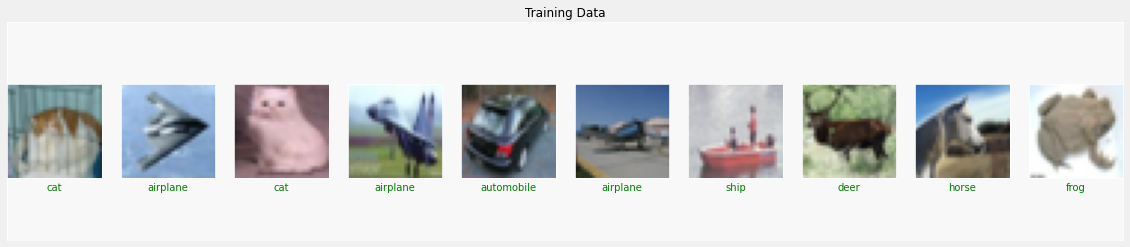

In [5]:
display_images(trainX, trainy, trainy, "Training Data" )

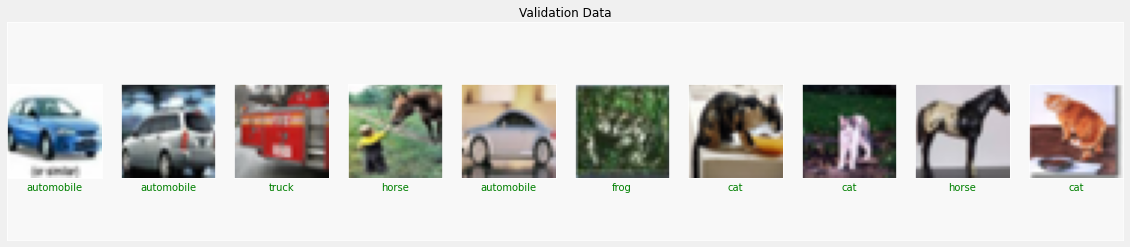

In [6]:
display_images(testX, testy, testy, "Validation Data" )

## *Preprocess the dataset*

In [7]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = preprocess_input(input_images)
  return output_ims

In [8]:
x_train = preprocess_image_input(trainX)
x_test = preprocess_image_input(testX)

In [9]:
x_train.shape,len(x_train),x_train[4].shape

((50000, 32, 32, 3), 50000, (32, 32, 3))

In [10]:
y_train=trainy
y_test=testy
y_train.shape,y_test.shape  

((50000, 1), (10000, 1))

#### Model Creation

In [11]:
# TL_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
TL_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) 
                                                                                       

9420800/9406464 [==============================] - 0s 0us/step


In [12]:
len(TL_base.layers)

154

In [13]:
# names of TL_base
print([x.name for x in TL_base.layers],end=' ') 

['input_1', 'Conv1', 'bn_Conv1', 'Conv1_relu', 'expanded_conv_depthwise', 'expanded_conv_depthwise_BN', 'expanded_conv_depthwise_relu', 'expanded_conv_project', 'expanded_conv_project_BN', 'block_1_expand', 'block_1_expand_BN', 'block_1_expand_relu', 'block_1_pad', 'block_1_depthwise', 'block_1_depthwise_BN', 'block_1_depthwise_relu', 'block_1_project', 'block_1_project_BN', 'block_2_expand', 'block_2_expand_BN', 'block_2_expand_relu', 'block_2_depthwise', 'block_2_depthwise_BN', 'block_2_depthwise_relu', 'block_2_project', 'block_2_project_BN', 'block_2_add', 'block_3_expand', 'block_3_expand_BN', 'block_3_expand_relu', 'block_3_pad', 'block_3_depthwise', 'block_3_depthwise_BN', 'block_3_depthwise_relu', 'block_3_project', 'block_3_project_BN', 'block_4_expand', 'block_4_expand_BN', 'block_4_expand_relu', 'block_4_depthwise', 'block_4_depthwise_BN', 'block_4_depthwise_relu', 'block_4_project', 'block_4_project_BN', 'block_4_add', 'block_5_expand', 'block_5_expand_BN', 'block_5_expand_

In [14]:
# TL_base.layers[81].name,TL_base.layers[143].name  # resnet50
TL_base.layers[81].name,TL_base.layers[107].name # mobilenetV2

('block_9_expand', 'block_12_expand')

Let's get an idea on how the ResNet architecture looks

In [15]:
TL_base.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [16]:
TL_base.layers[-1].get_config() 

{'dtype': 'float32',
 'max_value': array(6., dtype=float32),
 'name': 'out_relu',
 'negative_slope': array(0., dtype=float32),
 'threshold': array(0., dtype=float32),
 'trainable': True}

In [17]:
TL_base.trainable = False  

In [18]:
model = models.Sequential()
model.add(keras.Input(shape=(32,32,3)))
model.add(layers.UpSampling2D((7,7)))  # 32*7 = 224 
model.add(TL_base)
model.add(layers.GlobalAveragePooling2D()) # (7,7,2048) => (2048,)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(10, activation='softmax'))

# model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 
model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',  # sparse_categorical_crossentropy
                metrics = ['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                          

In [20]:
# Plot model
#from tensorflow.keras.utils import plot_model
#plot_model(model, show_shapes=True, show_layer_names=True, to_file='model_S.png')

In [21]:
from tensorflow.keras import layers, models, callbacks

In [22]:
mc_callback = callbacks.ModelCheckpoint(filepath="./model/cifar10_pct100_mobilenetV2S_SGD_best_weights.{epoch:03d}-{val_accuracy:.4f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)   
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=5)

In [24]:
%%time
history = model.fit(x_train, y_train, 
                    epochs=10, batch_size=50, 
                    validation_data=(x_test, y_test),
                    callbacks=[mc_callback,es_callback])

Epoch 1/10
1000/1000 [==============================] - ETA: 0s - loss: 1.0369 - accuracy: 0.6355

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1000/1000 [==============================] - 255s 255ms/step - loss: 1.0369 - accuracy: 0.6355 - val_loss: 0.8426 - val_accuracy: 0.7049
Epoch 2/10
1000/1000 [==============================] - 225s 225ms/step - loss: 0.9728 - accuracy: 0.6584 - val_loss: 0.8161 - val_accuracy: 0.7125
Epoch 3/10
1000/1000 [==============================] - 223s 223ms/step - loss: 0.9315 - accuracy: 0.6734 - val_loss: 0.7945 - val_accuracy: 0.7222
Epoch 4/10
1000/1000 [==============================] - 228s 228ms/step - loss: 0.8926 - accuracy: 0.6861 - val_loss: 0.7732 - val_accuracy: 0.7286
Epoch 5/10
1000/1000 [==============================] - 244s 244ms/step - loss: 0.8736 - accuracy: 0.6936 - val_loss: 0.7590 - val_accuracy: 0.7336
Epoch 6/10
1000/1000 [==============================] - 241s 241ms/step - loss: 0.8480 - accuracy: 0.7022 - val_loss: 0.7535 - val_accuracy: 0.7340
Epoch 7/10
1000/1000 [==============================] - 252s 252ms/step - loss: 0.8344 - accuracy: 0.7077 - val_loss: 0.739

#save the best model

>cifar10_pct100_mobilenetV2S_SGD_best_weights.009-0.7477.hdf5

In [25]:
model.evaluate(x_test, y_test, batch_size=50)

200/200 [==============================] - 31s 154ms/step - loss: 0.7128 - accuracy: 0.7498


[0.7128268480300903, 0.7498000264167786]

###Prediction using the best mode, Confusion matrix


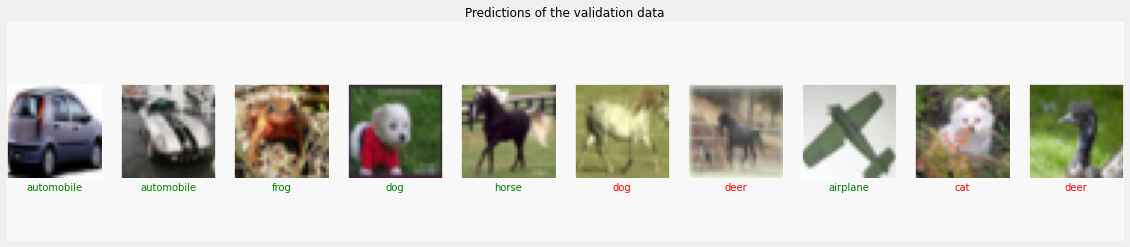

In [26]:
probabilities = model.predict(x_test, batch_size=50)
probabilities = np.argmax(probabilities, axis = 1)

display_images(testX, probabilities, testy, "Predictions of the validation data")

---

#Fine Tuning

In [27]:
# Unfreeze all layers in base model
tf.keras.backend.clear_session()  # For memory ->2번 라인 주석처리해도 상관없음
TL_base.trainable = True

In [28]:
print("Number of layers in the base model: ", len(TL_base.layers))

Number of layers in the base model:  154


In [29]:
# Fine-tune from this layer onwards
fine_tune_at = 107  # 81, 107 for mobilenetV2

# Freeze all the layers before the `fine_tune_at` layer
for layer in TL_base.layers[:fine_tune_at]:
  layer.trainable =  False

In [30]:
# Compile model
model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',  # sparse_categorical_crossentropy
                metrics = ['accuracy']) 

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                          

In [32]:
mc_callback = callbacks.ModelCheckpoint(filepath="./model/cifar10_pct100_mobileNetV2S_FT_SGD_best_weights.{epoch:03d}-{val_accuracy:.4f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=5)

